In [1]:
!pip install bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 MB 33.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
from transformers import AutoTokenizer, AutoModel, Trainer, TrainingArguments, DataCollatorWithPadding

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"

In [3]:
!nvidia-smi

Sun Apr  6 19:01:43 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   37C    P8             12W /   72W |       1MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
train_df = pd.read_csv('/kaggle/input/60k-data-with-context-v2/all_12_with_context2.csv')
valid_df = pd.read_csv('/kaggle/input/60k-data-with-context-v2/train_with_context2.csv')

train_df

,prompt,context,A,B,C,D,E,answer,source
0,"In relation to Eunice Fay McKenzie's career, w...","Eunice Fay McKenzie (February 19, 1918 – April...",McKenzie showcased her singing talents in nume...,McKenzie is primarily remembered for her starr...,McKenzie gained recognition for her role as a ...,McKenzie's collaborations with director Blake ...,McKenzie's successful career in sound films co...,B,1
1,How does Modified Newtonian Dynamics (MOND) im...,The presence of a clustered thick disk-like co...,MOND is a theory that increases the discrepanc...,MOND explains the missing baryonic mass in gal...,MOND is a theory that reduces the observed mis...,MOND is a theory that eliminates the observed ...,MOND's impact on the observed missing baryonic...,E,1
2,Which of the following statements accurately d...,Woody Hartman is a retired American soccer goa...,Ray Montgomerie is a former footballer who pla...,Ray Montgomerie is a former footballer who pla...,Ray Montgomerie is a former footballer who pla...,Ray Montgomerie is a former footballer who pla...,Ray Montgomerie is a former footballer who pla...,B,1
3,What is the significance of the Museum of the ...,The Museum of the Occupation of Latvia () is a...,The Museum of the Occupation of Latvia is a me...,The Museum of the Occupation of Latvia showcas...,The Museum of the Occupation of Latvia was est...,The Museum of the Occupation of Latvia primari...,The Museum of the Occupation of Latvia is a mu...,C,1
4,What was the previous name of the Christian Sc...,It was named the Evangelical School for the De...,The Christian School for the Deaf (CSD),The Christian School for the Blind (CSB),The Evangelical School and Chapel for the Deaf...,The Evangelical School for the Deaf (ESD),The Evangelical School for the Blind (ESB),D,1
...,...,...,...,...,...,...,...,...,...
60342,"The outer ear, or ear canal, carries sound to ...","The ear canal (external acoustic meatus, exter...",aorta,ear lobe,eardrum,lungs,NaN,C,12
60343,What sport involves people quickly finding des...,Orienteering sports in which route choice is a...,mapping,NaN,orienteering,patterning,sticking,C,12
60344,Almost all earthquakes occur at which place?,This subduction zone led to the formation of t...,mountains,land boundaries,plate boundaries,continental shelf,NaN,C,12
60345,"Melting glaciers, rising temperatures and drou...",Impacts include changes in regional rainfall p...,nature's natural cycle,air pollution,global warming,sudden warming,NaN,C,12


In [5]:
train_df.isnull().sum()

prompt        0
context       0
A          2796
B          2673
C          2681
D          2787
E          2740
answer        0
source        0
dtype: int64

In [6]:
NUM_TRAIN_SAMPLES = 10000
train_df = train_df.fillna('').sample(NUM_TRAIN_SAMPLES, random_state=42)

In [7]:
# debertav3-base 모델의 토크나이저 불러오기
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-large")

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/580 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [8]:
print(tokenizer.vocab_size)
print(tokenizer.cls_token, tokenizer.eos_token)

128000
[CLS] [SEP]


### Multiclass Classification + Deberta(encoder-only)

,prompt,context,A,B,C,D,E,answer,source
55314,What type of molecules are secreted by the cel...,B)) Local hormones are a large group of signal...,messenger molecules,negaitive molecules,,word molecules,sleeping molecules,A,10
4883,What type of sound did Ambrosia adopt on their...,Life Beyond L.A. is the third album by Ambrosi...,The album featured a heavier emphasis on progr...,The album explored a more experimental and ava...,"The album experimented with electronic music, ...",The album featured a fusion of progressive roc...,The album marked a departure from their progre...,E,2
29115,What is the traditional dish made with pounded...,* Puto kutsinta (typically just called kutsint...,Kiritanpo,Sushi,Gyūtan,Okonomiyaki,Takoyaki,A,5
4894,When was Gradius III first released for the Su...,Gradius III is a 1989 scrolling shooter video ...,It was never released for the SNES.,1990,1992,1991,1989,D,2
30959,"How did the name ""Bhārät"" evolve to refer to t...",Bharat (occasionally also romanised as Bharath...,It was derived from the name of Rishabha's son...,It was derived from the name of Dushyanta's so...,It was officially designated as the name for I...,It was developed as a result of the linguistic...,It was initially used to refer to the western ...,E,5


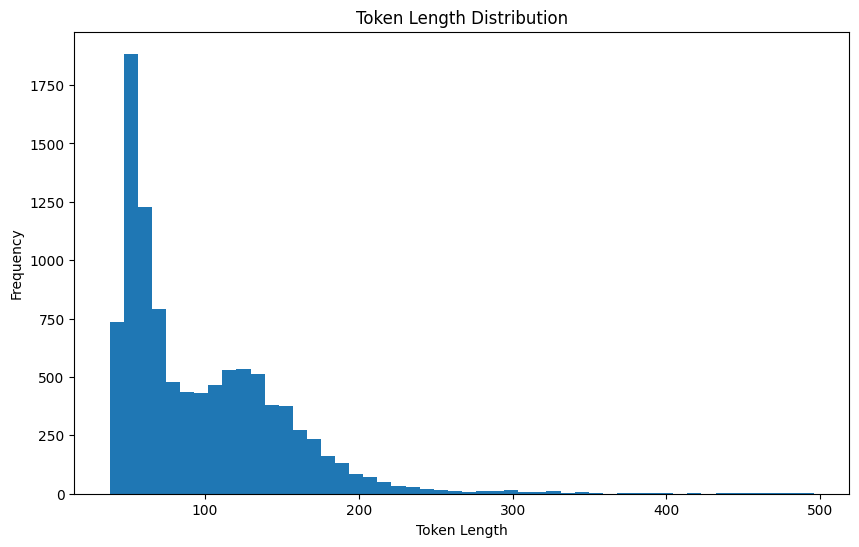


예시 토큰화 결과:
Example 1:
Original: What type of molecules are secreted by the cell in local signaling?
###
A: messenger molecules
###
B: negaitive molecules
###
C: 
###
D: word molecules
###
E: sleeping molecules
###
Answer: 
Tokens: ['▁What', '▁type', '▁of', '▁molecules', '▁are', '▁secreted', '▁by', '▁the', '▁cell', '▁in', '▁local', '▁signaling', '?', '▁#', '#', '#', '▁A', ':', '▁messenger', '▁molecules', '▁#', '#', '#', '▁B', ':', '▁neg', 'a', 'itive', '▁molecules', '▁#', '#', '#', '▁C', ':', '▁#', '#', '#', '▁D', ':', '▁word', '▁molecules', '▁#', '#', '#', '▁E', ':', '▁sleeping', '▁molecules', '▁#', '#', '#', '▁Answer', ':']
Length: 53
----------------------------------------
Example 2:
Original: What type of sound did Ambrosia adopt on their album Life Beyond L.A.?
###
A: The album featured a heavier emphasis on progressive rock, continuing their roots in the genre.
###
B: The album explored a more experimental and avant-garde sound, incorporating elements of free jazz and atonal com

In [9]:
# 필요한 라이브러리 임포트
import pandas as pd
from transformers import AutoTokenizer
import matplotlib.pyplot as plt


# 데이터의 앞부분 몇 개 샘플 출력
display(train_df.head())

texts = (train_df['prompt'] + '\n###\nA: ' + train_df['A'] + '\n###\nB: ' + train_df['B']+ '\n###\nC: ' + train_df['C']+ '\n###\nD: ' + train_df['D']+ '\n###\nE: ' + train_df['E']+ '\n###\nAnswer: ').tolist()
# pre-tokenize: 각 텍스트에 대해 토큰화 진행
tokenized_texts = [tokenizer.tokenize(text) for text in texts]

# 각 텍스트별 토큰 길이 계산
token_lengths = [len(tokens) for tokens in tokenized_texts]

# 토큰 길이 분포 시각화
plt.figure(figsize=(10, 6))
plt.hist(token_lengths, bins=50)
plt.xlabel("Token Length")
plt.ylabel("Frequency")
plt.title("Token Length Distribution")
plt.show()

# 몇 개의 예시 토큰화 결과 출력
print("\n예시 토큰화 결과:")
for i in range(5):
    print(f"Example {i+1}:")
    print("Original:", texts[i])
    print("Tokens:", tokenized_texts[i])
    print("Length:", len(tokenized_texts[i]))
    print("-" * 40)


In [10]:
def custom_tokenize(tokenizer, text1, text2, max_length):
    #전체 토큰 길이 max_length을 넘지 않도록 trucnate
    #text2의 길이가 max_length을 초과하면, text2의 앞부분을 truncate, 이후 text1의 뒷부분을 truncate

    tokenizer.truncation_side='left'
    text2_encoded = tokenizer.encode(
        text2,
        truncation=True,
        max_length=max_length,
        add_special_tokens=False
    )

    text2_len = len(text2_encoded)
    
    if text2_len < max_length:
        tokenizer.truncation_side='right'
        text1_encoded = tokenizer.encode(
            text1,
            truncation=True,
            max_length=max_length-text2_len,
            add_special_tokens=False
        )
    else:
        text1_encoded = []

    input_ids = text1_encoded + text2_encoded
    attention_mask = [1] * len(input_ids)
    return {"input_ids": input_ids, "attention_mask": attention_mask}


def preprocess_function_classification(examples, tokenizer=tokenizer):
    input_ids = []
    labels = []
    attention_masks = []
    label_mapping = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
    for q, A, B, C, D, E, answer in zip(examples['prompt'], examples['A'], examples['B'], examples['C'], examples['D'], examples['E'], examples['answer']):
        text1 = tokenizer.cls_token + q #q
        text2 = '\n###\nA: ' + A + '\n###\nB: ' + B + '\n###\nC: ' + C + '\n###\nD: ' + D + '\n###\nE: ' + E + tokenizer.eos_token
        # tokenized = tokenizer(text1, text2, max_length=MAX_LEN, truncation='only_first')
        tokenized = custom_tokenize(tokenizer, text1, text2, max_length=512)
        input_ids.append(tokenized['input_ids'])
        labels.append(label_mapping[answer])
        attention_masks.append(tokenized['attention_mask'])
    return {'input_ids': input_ids, 'labels': labels, 'attention_mask': attention_masks}

In [11]:
from datasets import load_dataset
from datasets import Dataset, DatasetDict

train_dataset = Dataset.from_pandas(train_df)
valid_dataset = Dataset.from_pandas(valid_df)

dataset = DatasetDict({
    "train": train_dataset,
    "validation": valid_dataset
})

tokenized_dataset = dataset.map(preprocess_function_classification, batched=True)
tokenized_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
tokenized_dataset['train'][0]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

{'input_ids': tensor([    1,   458,   810,   265, 10157,   281, 48291,   293,   262,  1874,
           267,   588, 12540,   302,   953,  2669,  2669,   336,   294, 19292,
         10157,   953,  2669,  2669,   736,   294, 51257,   452, 40955, 10157,
           953,  2669,  2669,   716,   294,   953,  2669,  2669,   802,   294,
          1180, 10157,   953,  2669,  2669,   829,   294,  4869, 10157,     2]),
 'labels': tensor(0),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1])}

In [12]:
from transformers import AutoModelForSequenceClassification
# 옵션: 다중 분류 (예: A, B, C, D, E → 5 classes)
num_labels = 5
model = AutoModelForSequenceClassification.from_pretrained("microsoft/deberta-v3-large", torch_dtype=torch.bfloat16, num_labels=num_labels)#, attn_implementation="flash_attention_2")

#test forward
test_input_ids = torch.randint(0, 100, (1, 512))
test_attention_mask = torch.ones_like(test_input_ids)
test_labels = torch.randint(0, 5, (1,))

outputs = model(test_input_ids, test_attention_mask, test_labels)
print(outputs)

pytorch_model.bin:   0%|          | 0.00/874M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


SequenceClassifierOutput(loss=None, logits=tensor([[-0.0894,  0.1562,  0.2520,  0.1348, -0.0369]], dtype=torch.bfloat16,
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)


In [13]:
torch.cuda.empty_cache()

############################
# 4. TrainingArguments 및 Trainer 설정
############################
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="steps",
    eval_steps=100,                  # 평가 스텝 (사용자 설정 가능)
    logging_steps=100,               # 로깅 스텝
    warmup_ratio=0.1,
    learning_rate=2e-5,
    optim='paged_adamw_32bit', #'paged_adamw_32bit', 'paged_adamw_8bit', 'adamw_torch'
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=1,
    save_only_model=True,
    report_to="none",
    bf16=True,
    torch_compile=True,
    # fp16=True,
    lr_scheduler_type='cosine',
    # 필요시 추가 argument 지정 가능
)

def map_at_3(predictions, labels):
    map_sum = 0
    pred = np.argsort(-1*np.array(predictions),axis=1)[:,:3]
    for x,y in zip(pred,labels):
        z = [1/i if y==j else 0 for i,j in zip([1,2,3],x)]
        map_sum += np.sum(z)
    return map_sum / len(predictions)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    accuracy = (preds == labels).mean()
    return {"accuracy": accuracy, "map_at_3": map_at_3(logits, labels)}

# 동적 padding을 위한 DataCollator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding='longest', max_length=512)

# Trainer 초기화
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

############################
# 5. 학습 시작
############################
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,Map At 3
100,1.624700,1.609103,0.200000,0.385833
200,1.612000,1.608441,0.200000,0.383333
300,1.612300,1.605948,0.225000,0.398333
400,1.614200,1.607202,0.200000,0.383333
500,1.610800,1.607135,0.200000,0.384167
600,1.606700,1.606657,0.220000,0.395833
700,1.609400,1.606786,0.205000,0.386667
800,1.611300,1.606772,0.215000,0.392500
900,1.607500,1.606704,0.210000,0.390000


TrainOutput(global_step=939, training_loss=1.6121173529579236, metrics={'train_runtime': 1499.7229, 'train_samples_per_second': 20.004, 'train_steps_per_second': 0.626, 'total_flos': 1.3230066665142624e+16, 'train_loss': 1.6121173529579236, 'epoch': 3.0})

In [14]:
import shutil
shutil.rmtree("./results")

### Multiple Choice + Deberta(encoder-only)

In [15]:
MAX_LEN = 256

In [16]:
from dataclasses import dataclass
from typing import Optional, Union, Any
from transformers.tokenization_utils_base import PreTrainedTokenizerBase, PaddingStrategy


def preprocess_function_multiple_choice(examples, tokenizer=tokenizer):
    input_ids = []
    label = []
    attention_masks = []
    # print(examples)
    label_mapping = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
    for q, A, B, C, D, E, answer in zip(examples['prompt'], examples['A'], examples['B'], examples['C'], examples['D'], examples['E'], examples['answer']):
        text1 = [ tokenizer.cls_token + q ] * 5
        text2 = ["\n###\n" + option + tokenizer.eos_token for option in [A,B,C,D,E]]
        tokenized = [custom_tokenize(tokenizer, t1, t2, max_length=256) for t1, t2 in zip(text1, text2)]
        input_ids.append([x['input_ids'] for x in tokenized])
        label.append(label_mapping[answer])
        attention_masks.append([x['attention_mask'] for x in tokenized])
        
    return {'input_ids': input_ids, 'labels': label, 'attention_mask': attention_masks}

@dataclass
class DataCollatorForMultipleChoice:
    tokenizer: PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    
    def __call__(self, features):
        label_name = 'label' if 'label' in features[0].keys() else 'labels'
        labels = [feature.pop(label_name) for feature in features]
        batch_size = len(features)
        num_choices = len(features[0]['input_ids'])
        flattened_features = [
            [{k: v[i] for k, v in feature.items()} for i in range(num_choices)] for feature in features
        ]
        flattened_features = sum(flattened_features, [])
        
        batch = self.tokenizer.pad(
            flattened_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors='pt',
        )
        batch = {k: v.view(batch_size, num_choices, -1) for k, v in batch.items()}
        batch['labels'] = torch.tensor(labels, dtype=torch.int64)
        return batch

In [17]:
train_dataset = Dataset.from_pandas(train_df)
valid_dataset = Dataset.from_pandas(valid_df)

dataset = DatasetDict({
    "train": train_dataset,
    "validation": valid_dataset
})


tokenized_dataset = dataset.map(preprocess_function_multiple_choice, batched=True)
tokenized_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
tokenized_dataset['train'][0]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

{'input_ids': [tensor([    1,   458,   810,   265, 10157,   281, 48291,   293,   262,  1874,
            267,   588, 12540,   302,   953,  2669,  2669, 19292, 10157,     2]),
  tensor([    1,   458,   810,   265, 10157,   281, 48291,   293,   262,  1874,
            267,   588, 12540,   302,   953,  2669,  2669, 51257,   452, 40955,
          10157,     2]),
  tensor([    1,   458,   810,   265, 10157,   281, 48291,   293,   262,  1874,
            267,   588, 12540,   302,   953,  2669,  2669,     2]),
  tensor([    1,   458,   810,   265, 10157,   281, 48291,   293,   262,  1874,
            267,   588, 12540,   302,   953,  2669,  2669,  1180, 10157,     2]),
  tensor([    1,   458,   810,   265, 10157,   281, 48291,   293,   262,  1874,
            267,   588, 12540,   302,   953,  2669,  2669,  4869, 10157,     2])],
 'labels': tensor(0),
 'attention_mask': [tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [18]:
x = DataCollatorForMultipleChoice(tokenizer, max_length=MAX_LEN)([tokenized_dataset['train'][0] for _ in range(2)])
print(x)
print(x['input_ids'].shape, x['attention_mask'].shape, x['labels'].shape)

You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'input_ids': tensor([[[    1,   458,   810,   265, 10157,   281, 48291,   293,   262,  1874,
            267,   588, 12540,   302,   953,  2669,  2669, 19292, 10157,     2,
              0,     0],
         [    1,   458,   810,   265, 10157,   281, 48291,   293,   262,  1874,
            267,   588, 12540,   302,   953,  2669,  2669, 51257,   452, 40955,
          10157,     2],
         [    1,   458,   810,   265, 10157,   281, 48291,   293,   262,  1874,
            267,   588, 12540,   302,   953,  2669,  2669,     2,     0,     0,
              0,     0],
         [    1,   458,   810,   265, 10157,   281, 48291,   293,   262,  1874,
            267,   588, 12540,   302,   953,  2669,  2669,  1180, 10157,     2,
              0,     0],
         [    1,   458,   810,   265, 10157,   281, 48291,   293,   262,  1874,
            267,   588, 12540,   302,   953,  2669,  2669,  4869, 10157,     2,
              0,     0]],

        [[    1,   458,   810,   265, 10157,   281, 48291, 

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2691: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


In [19]:
from transformers import AutoModelForMultipleChoice
model = AutoModelForMultipleChoice.from_pretrained("microsoft/deberta-v3-large")

#test forward
test_input_ids = torch.randint(0, 100, (1, 5, 512))
test_attention_mask = torch.ones_like(test_input_ids)
test_labels = torch.randint(0, 5, (1,))

outputs = model(test_input_ids, test_attention_mask, test_labels)
print(outputs)

Some weights of DebertaV2ForMultipleChoice were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


MultipleChoiceModelOutput(loss=None, logits=tensor([[0.2512, 0.3479, 0.4061, 0.4481, 0.4105]], grad_fn=<ViewBackward0>), hidden_states=None, attentions=None)


In [20]:
torch.cuda.empty_cache()

############################
# 4. TrainingArguments 및 Trainer 설정
############################
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="steps",
    eval_steps=100,                  # 평가 스텝 (사용자 설정 가능)
    logging_steps=100,               # 로깅 스텝
    warmup_ratio=0.1,
    learning_rate=2e-5,
    optim='paged_adamw_32bit', #'paged_adamw_32bit', 'paged_adamw_8bit', 'adamw_torch'
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=1,
    weight_decay=0.01,
    save_total_limit=1,
    report_to="none",
    save_only_model=True,
    bf16=True,
    torch_compile=True,
    # fp16=True,
    lr_scheduler_type='cosine',
    # 필요시 추가 argument 지정 가능
)

def map_at_3(predictions, labels):
    map_sum = 0
    pred = np.argsort(-1*np.array(predictions),axis=1)[:,:3]
    for x,y in zip(pred,labels):
        z = [1/i if y==j else 0 for i,j in zip([1,2,3],x)]
        map_sum += np.sum(z)
    return map_sum / len(predictions)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    accuracy = (preds == labels).mean()
    return {"accuracy": accuracy, "map_at_3": map_at_3(logits, labels)}

# 동적 padding을 위한 DataCollator
data_collator = DataCollatorForMultipleChoice(tokenizer=tokenizer, padding='longest', max_length=256)

# Trainer 초기화
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

############################
# 5. 학습 시작
############################
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,Map At 3
100,1.530900,1.470556,0.555000,0.694167
200,1.258700,1.048972,0.595000,0.726667
300,1.173700,0.983084,0.645000,0.760833
400,1.078100,0.958892,0.645000,0.767500
500,1.077000,0.924035,0.665000,0.780000
600,1.068200,0.892977,0.660000,0.777500


TrainOutput(global_step=625, training_loss=1.1920725830078125, metrics={'train_runtime': 701.9269, 'train_samples_per_second': 14.246, 'train_steps_per_second': 0.89, 'total_flos': 5805951972280320.0, 'train_loss': 1.1920725830078125, 'epoch': 1.0})

In [21]:
import shutil
shutil.rmtree("./results")

In [22]:
############################
# 3. 모델 정의 (마지막 유효 토큰의 hidden state 이용)
############################
class PretrainedClassificationModel(nn.Module):
    def __init__(self, model_name, num_labels, dropout_rate=0.1, dtype=torch.bfloat16):
        super(PretrainedClassificationModel, self).__init__()
        self.num_labels = num_labels
        self.model = AutoModel.from_pretrained(model_name, torch_dtype=dtype)#, attn_implementation="flash_attention_2")
        hidden_size = self.model.config.hidden_size
        # self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(hidden_size, num_labels, dtype=dtype)
    
    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state  # (batch_size, seq_len, hidden_size)

        # 각 예시마다 attention_mask의 합 - 1 을 통해 마지막 유효 토큰의 인덱스 계산
        seq_lengths = attention_mask.sum(dim=1) - 1  # shape: (batch_size)
        batch_size = input_ids.size(0)
        # 각 샘플의 마지막 유효 토큰의 hidden state 추출
        last_token_states = last_hidden_state[torch.arange(batch_size), seq_lengths]
        # last_token_states = self.dropout(last_token_states)
            
        logits = self.classifier(last_token_states)
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)
        return {'loss': loss, 'logits': logits} if loss is not None else logits


class PretrainedMultipleChoiceModel(nn.Module):
    def __init__(self, model_name, dropout_rate=0.1, dtype=torch.bfloat16):
        super(PretrainedMultipleChoiceModel, self).__init__()
        self.num_labels = num_labels
        self.model = AutoModel.from_pretrained(model_name, torch_dtype=dtype)#, attn_implementation="flash_attention_2")
        hidden_size = self.model.config.hidden_size
        # self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(hidden_size, 1, dtype=dtype)
    
    def forward(self, input_ids, attention_mask, labels=None):
        bs, n_options, seq_len = input_ids.shape
        input_ids, attention_mask = input_ids.view(-1, seq_len), attention_mask.view(-1, seq_len)
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state  # (batch_size*n_options, seq_len, hidden_size)

        # 각 예시마다 attention_mask의 합 - 1 을 통해 마지막 유효 토큰의 인덱스 계산
        seq_lengths = attention_mask.sum(dim=1) - 1  # shape: (batch_size)
        batch_size = input_ids.size(0)
        # 각 샘플의 마지막 유효 토큰의 hidden state 추출
        last_token_states = last_hidden_state[torch.arange(batch_size), seq_lengths]
        # last_token_states = self.dropout(last_token_states)
            
        logits = self.classifier(last_token_states) #(batch_size*n_options, 1)
        logits = logits.view(bs, n_options)
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)
        # if labels is not None:
        #     labels = F.one_hot(labels, n_options).to(logits.dtype)
        #     loss_fct = nn.BCEWithLogitsLoss()
        #     loss = loss_fct(logits, labels)
        
        return {'loss': loss, 'logits': logits} if loss is not None else logits

### Classification + Causal LLM(decoder-only)

In [23]:
tokenizer = AutoTokenizer.from_pretrained("/kaggle/input/llama-3.2/transformers/1b/1")
model = PretrainedClassificationModel(model_name = "/kaggle/input/llama-3.2/transformers/1b/1",
        num_labels = 5,
        dtype = torch.bfloat16)
tokenizer.pad_token = tokenizer.eos_token

In [24]:
# # 4bit quantization
# from bitsandbytes import BitsAndBytesConfig         

# quantization_config=BitsAndBytesConfig(
#             load_in_4bit=True,
#             bnb_4bit_compute_dtype=torch.bfloat16,
#             bnb_4bit_use_double_quant=True,
#             bnb_4bit_quant_type='nf4'
#         ),

# model = AutoModel('model_name', quantization_config = quantization_cofig, load_in_4bit=True, torch_dtype=torch.bfloat16)

# Use LoRA
# from peft import LoraConfig, get_peft_model, TaskType

# peft_config = LoraConfig(
#     r=8, #rank of low-rank matrices, low rank -> low VRAM usage
#     lora_alpha=4, 
#     lora_dropout=0.1, 
#     bias="none", 
#     task_type="CAUSAL_LM",
#     target_modules=["q_proj", "k_proj"], #modules to apply LORA
#     # modules_to_save=['lm_head'], #modules to finetune without LORA
#     inference_mode=False, 
# )
# model = get_peft_model(model, peft_config)
# print(model.model.model.embed_tokens.weight.requires_grad)
# print(model.model.lm_head.weight.requires_grad)
# # model.model.embed_tokens.requires_grad = False
# model.print_trainable_parameters()

In [25]:
def preprocess_function_classification(examples, tokenizer=tokenizer):
    input_ids = []
    labels = []
    attention_masks = []
    label_mapping = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
    for q, A, B, C, D, E, answer in zip(examples['prompt'], examples['A'], examples['B'], examples['C'], examples['D'], examples['E'], examples['answer']):
        text1 = "Question: " + q #tokenizer.cls_token + q
        text2 = '\n###\nA: ' + A + '\n###\nB: ' + B + '\n###\nC: ' + C + '\n###\nD: ' + D + '\n###\nE: ' + E + '\n###\nAnswer:'
        # text2 = '\nA: ' + A + '\nB: ' + B + '\nC: ' + C + '\nD: ' + D + '\nE: ' + E + tokenizer.eos_token
        # tokenized = tokenizer(text1, text2, max_length=MAX_LEN, truncation='only_first')
        tokenized = custom_tokenize(tokenizer, text1, text2, max_length=512)
        input_ids.append(tokenized['input_ids'])
        labels.append(label_mapping[answer])
        attention_masks.append(tokenized['attention_mask'])
    return {'input_ids': input_ids, 'labels': labels, 'attention_mask': attention_masks}
    
def preprocess_function_multiple_choice(examples, tokenizer=tokenizer):
    input_ids = []
    label = []
    attention_masks = []
    # print(examples)
    label_mapping = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
    for q, A, B, C, D, E, answer in zip(examples['prompt'], examples['A'], examples['B'], examples['C'], examples['D'], examples['E'], examples['answer']):
        text1 = [ "Question: " + q ] * 5 #[ tokenizer.cls_token + q ] * 5
        text2 = ["\n###\nAnswer: " + option + "\n###\nTrue or False:" for option in [A,B,C,D,E]]
        tokenized = [custom_tokenize(tokenizer, t1, t2, max_length=256) for t1, t2 in zip(text1, text2)]
        input_ids.append([x['input_ids'] for x in tokenized])
        label.append(label_mapping[answer])
        attention_masks.append([x['attention_mask'] for x in tokenized])
        
    return {'input_ids': input_ids, 'labels': label, 'attention_mask': attention_masks}

In [26]:
from datasets import load_dataset
from datasets import Dataset, DatasetDict

train_dataset = Dataset.from_pandas(train_df)
valid_dataset = Dataset.from_pandas(valid_df)

dataset = DatasetDict({
    "train": train_dataset,
    "validation": valid_dataset
})

tokenized_dataset = dataset.map(preprocess_function_classification, batched=True)
tokenized_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
tokenized_dataset['train'][0]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

{'input_ids': tensor([14924,    25,  3639,   955,   315, 35715,   527,  6367,   291,   555,
           279,  2849,   304,  2254, 43080,    30,   198, 27938,    32,    25,
         50596, 35715,   198, 27938,    33,    25,  4277,  1339,   535, 35715,
           198, 27938,    34,    25,   720, 27938,    35,    25,  3492, 35715,
           198, 27938,    36,    25, 21811, 35715,   198, 27938, 16533,    25]),
 'labels': tensor(0),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1])}

In [27]:
torch.cuda.empty_cache()

############################
# 4. TrainingArguments 및 Trainer 설정
############################
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="steps",
    eval_steps=100,                  # 평가 스텝 (사용자 설정 가능)
    logging_steps=100,               # 로깅 스텝
    warmup_ratio=0.1,
    learning_rate=2e-5,
    optim='paged_adamw_32bit', #'paged_adamw_32bit', 'paged_adamw_8bit', 'adamw_torch'
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=1,
    save_only_model=True,
    report_to="none",
    bf16=True,
    torch_compile=True,
    # fp16=True,
    lr_scheduler_type='cosine',
    # 필요시 추가 argument 지정 가능
)

def map_at_3(predictions, labels):
    map_sum = 0
    pred = np.argsort(-1*np.array(predictions),axis=1)[:,:3]
    for x,y in zip(pred,labels):
        z = [1/i if y==j else 0 for i,j in zip([1,2,3],x)]
        map_sum += np.sum(z)
    return map_sum / len(predictions)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    accuracy = (preds == labels).mean()
    return {"accuracy": accuracy, "map_at_3": map_at_3(logits, labels)}

# 동적 padding을 위한 DataCollator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding='longest', max_length=512)

# Trainer 초기화
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

############################
# 5. 학습 시작
############################
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,Map At 3
100,1.555800,1.358750,0.455000,0.590833
200,1.238800,1.356875,0.435000,0.567500
300,1.153400,1.189531,0.525000,0.665000
400,0.771800,1.155938,0.570000,0.700833
500,0.662000,1.207813,0.545000,0.697500
600,0.643700,1.077656,0.575000,0.713333
700,0.432100,1.237344,0.575000,0.712500
800,0.290400,1.264531,0.560000,0.701667
900,0.316100,1.260937,0.565000,0.704167


TrainOutput(global_step=939, training_loss=0.7649133781782481, metrics={'train_runtime': 2876.7701, 'train_samples_per_second': 10.428, 'train_steps_per_second': 0.326, 'total_flos': 0.0, 'train_loss': 0.7649133781782481, 'epoch': 3.0})

In [28]:
import shutil
shutil.rmtree("./results")

### Multipel Choice + Causal LLM(decoder-only)

In [29]:
tokenizer = AutoTokenizer.from_pretrained("/kaggle/input/llama-3.2/transformers/1b/1")
model = PretrainedMultipleChoiceModel(model_name = "/kaggle/input/llama-3.2/transformers/1b/1",
        dtype = torch.bfloat16)
tokenizer.pad_token = tokenizer.eos_token

In [30]:
from datasets import load_dataset
from datasets import Dataset, DatasetDict

train_dataset = Dataset.from_pandas(train_df)
valid_dataset = Dataset.from_pandas(valid_df)

dataset = DatasetDict({
    "train": train_dataset,
    "validation": valid_dataset
})

tokenized_dataset = dataset.map(preprocess_function_multiple_choice, batched=True)
tokenized_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
tokenized_dataset['train'][0]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

{'input_ids': [tensor([14924,    25,  3639,   955,   315, 35715,   527,  6367,   291,   555,
            279,  2849,   304,  2254, 43080,    30,   198, 27938, 16533,    25,
          50596, 35715,   198, 27938,  2575,   477,  3641,    25]),
  tensor([14924,    25,  3639,   955,   315, 35715,   527,  6367,   291,   555,
            279,  2849,   304,  2254, 43080,    30,   198, 27938, 16533,    25,
           4277,  1339,   535, 35715,   198, 27938,  2575,   477,  3641,    25]),
  tensor([14924,    25,  3639,   955,   315, 35715,   527,  6367,   291,   555,
            279,  2849,   304,  2254, 43080,    30,   198, 27938, 16533,    25,
            720, 27938,  2575,   477,  3641,    25]),
  tensor([14924,    25,  3639,   955,   315, 35715,   527,  6367,   291,   555,
            279,  2849,   304,  2254, 43080,    30,   198, 27938, 16533,    25,
           3492, 35715,   198, 27938,  2575,   477,  3641,    25]),
  tensor([14924,    25,  3639,   955,   315, 35715,   527,  6367,   291,   

In [31]:
torch.cuda.empty_cache()

############################
# 4. TrainingArguments 및 Trainer 설정
############################
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="steps",
    eval_steps=100,                  # 평가 스텝 (사용자 설정 가능)
    logging_steps=100,               # 로깅 스텝
    warmup_ratio=0.1,
    learning_rate=2e-5,
    optim='paged_adamw_32bit', #'paged_adamw_32bit', 'paged_adamw_8bit', 'adamw_torch'
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=1,
    weight_decay=0.01,
    save_total_limit=1,
    report_to="none",
    save_only_model=True,
    bf16=True,
    torch_compile=True,
    # fp16=True,
    lr_scheduler_type='cosine',
    # 필요시 추가 argument 지정 가능
)

def map_at_3(predictions, labels):
    map_sum = 0
    pred = np.argsort(-1*np.array(predictions),axis=1)[:,:3]
    for x,y in zip(pred,labels):
        z = [1/i if y==j else 0 for i,j in zip([1,2,3],x)]
        map_sum += np.sum(z)
    return map_sum / len(predictions)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    accuracy = (preds == labels).mean()
    return {"accuracy": accuracy, "map_at_3": map_at_3(logits, labels)}

# 동적 padding을 위한 DataCollator
data_collator = DataCollatorForMultipleChoice(tokenizer=tokenizer, padding='longest', max_length=256)

# Trainer 초기화
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

############################
# 5. 학습 시작
############################
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,Map At 3
100,1.372700,1.029063,0.650000,0.776667
200,1.100900,0.919062,0.650000,0.785833
300,1.058800,0.943281,0.645000,0.789167
400,0.964800,0.913125,0.680000,0.805000
500,0.980400,0.892812,0.690000,0.810000
600,0.972200,0.891250,0.680000,0.807500


TrainOutput(global_step=625, training_loss=1.073240625, metrics={'train_runtime': 1878.0299, 'train_samples_per_second': 5.325, 'train_steps_per_second': 0.333, 'total_flos': 0.0, 'train_loss': 1.073240625, 'epoch': 1.0})